# Import Necessary Libraries

In [1]:
import os
# import shutil
import pandas as pd
import pyreadstat
import numpy as np
# from PIL import Image
import pydicom
import matplotlib.pyplot as plt
import cv2
# from skimage import exposure
# from skimage import filters
# from sklearn.model_selection import train_test_split
import SimpleITK as sitk

# Define Necessary Functions

In [2]:
def get_patients_ages(data_labels, data_sav):
    patients_ages = []
    for i in range(len(data_labels)):
        if type(data_labels) == pd.core.frame.DataFrame:
            age = data_sav[data_sav.code==str(data_labels.iloc[i, 0])].age.to_numpy()[0]
        else:
            age = data_sav[data_sav.code==data_labels[i, 0]].age.to_numpy()[0]
        patients_ages.append(age)
        
    patients_ages = np.array(patients_ages)
    return patients_ages

In [3]:
def get_data_distribution(data_labels, data_sav):
    patients_fgt_distribution = np.zeros(4)
    for i in range(len(data_labels)):
        if type(data_labels) == pd.core.frame.DataFrame:
            fgt = data_sav[data_sav.code==str(data_labels.iloc[i, 0])].FG.to_numpy()[0]
        else:
            fgt = data_sav[data_sav.code==data_labels[i, 0]].FG.to_numpy()[0]
            
        fgt = int(fgt)-1
        patients_fgt_distribution[fgt] += 1
        
    return patients_fgt_distribution

In [4]:
# Each file name is a string.
def get_file_names(files_path):
    files_names = os.listdir(files_path)
    return files_names

# Extract Patients' Information

In [6]:
data_sav, meta = pyreadstat.read_sav('Full_Patients_Information.sav')
data_labels = pd.read_csv('data_labels.csv')

In [6]:
train_set_info = np.load("E:/Dataset Information/train_set_info.npy")
validation_set_info = np.load("E:/Dataset Information/validation_set_info.npy")
test_set_info = np.load("E:/Dataset Information/test_set_info.npy")

train_length = len(train_set_info)
validation_length = len(validation_set_info)
test_length = len(test_set_info)

dataset_length = train_length + validation_length + test_length

In [8]:
scanners_counters = np.zeros(2)

for i in range(len(test_set_info)):
    path = "E:/Others/Selected Data/" + train_set_info[i, 0] + "/FGT"
    file_names = get_file_names(path)
    dcm = pydicom.dcmread(path + "/" + file_names[0])
    manufacture = dcm[(0x0008, 0x1090)].value
    if manufacture == 'DISCOVERY MR750w':
        scanners_counters[0] += 1
    else:
        scanners_counters[1] += 1

In [9]:
print(f"There are {dataset_length} patients ({dataset_length} MRI scans) in the dataset.")
print(f"There are {train_length} patients ({train_length} MRI scans) in the train set.")
print(f"There are {validation_length} patients ({validation_length} MRI scans) in the validation set.")
print(f"There are {test_length} patients ({test_length} MRI scans) in the test set.")

There are 654 patients (654 MRI scans) in the dataset.
There are 498 patients (498 MRI scans) in the train set.
There are 57 patients (57 MRI scans) in the validation set.
There are 99 patients (99 MRI scans) in the test set.


In [10]:
patient_ages_all = get_patients_ages(data_labels, data_sav)
patient_ages_train = get_patients_ages(train_set_info, data_sav)
patient_ages_validation = get_patients_ages(validation_set_info, data_sav)
patient_ages_test = get_patients_ages(test_set_info, data_sav)

print(f"The mean age of the patients is {patient_ages_all.mean():.2f} ± {patient_ages_all.std():.2f}")
print(f"Youngest patient in the dataset is {patient_ages_all.min()} years old.")
print(f"Oldest patient in the dataset is {patient_ages_all.max()} years old.")
print(50*"#")
print(f"The mean age of the patients in training set is {patient_ages_train.mean():.2f} ± {patient_ages_train.std():.2f}")
print(50*"#")
print(f"The mean age of the patients in validation set is {patient_ages_validation.mean():.2f} ± {patient_ages_validation.std():.2f}")
print(50*"#")
print(f"The mean age of the patients in test set is {patient_ages_test.mean():.2f} ± {patient_ages_test.std():.2f}")

The mean age of the patients is 43.24 ± 9.64
Youngest patient in the dataset is 19.0 years old.
Oldest patient in the dataset is 76.0 years old.
##################################################
The mean age of the patients in training set is 43.56 ± 9.63
##################################################
The mean age of the patients in validation set is 42.54 ± 10.01
##################################################
The mean age of the patients in test set is 42.07 ± 9.37


In [11]:
train_distribution = get_data_distribution(train_set_info, data_sav)
validation_distribution = get_data_distribution(validation_set_info, data_sav)
test_distribution = get_data_distribution(test_set_info, data_sav)

print(f"Train Data Distribution: {train_distribution}")
print(f"Validation Data Distribution: {validation_distribution}")
print(f"Test Data Distribution: {test_distribution}")

Train Data Distribution: [ 42. 150. 184. 122.]
Validation Data Distribution: [ 5. 17. 21. 14.]
Test Data Distribution: [ 9. 30. 36. 24.]


In [12]:
manufactures_names = []
for i in range(len(data_labels)):
    path = "E:/Others/Selected Data/" + str(data_labels.iloc[i, 0]) + "/FGT"
    file_names = get_file_names(path)
    dcm = pydicom.dcmread(path + "/" + file_names[0])
    manufacture = dcm[(0x0008, 0x0070)].value
    manufactures_names.append(manufacture)
    
manufactures_names = np.array(manufactures_names)
print(np.unique(manufactures_names))

['GE MEDICAL SYSTEMS']


In [14]:
manufactures_models = []
for i in range(len(data_labels)):
    path = "E:/Others/Selected Data/" + str(data_labels.iloc[i, 0]) + "/FGT"
    file_names = get_file_names(path)
    dcm = pydicom.dcmread(path + "/" + file_names[0])
    manufacture = dcm[(0x0008, 0x1090)].value
    manufactures_models.append(manufacture)
    
manufactures_models = np.array(manufactures_models)
print(np.unique(manufactures_models))

['DISCOVERY MR750w' 'OPTIMA MR360' 'Optima MR360']


In [15]:
magnetic_field_DISCOVERY_MR750w = []
repetition_time_DISCOVERY_MR750w = []
echo_time_DISCOVERY_MR750w = []
matrix_size_DISCOVERY_MR750w = []
flip_angle_DISCOVERY_MR750w = []
field_of_view_DISCOVERY_MR750w = []
slice_number_DISCOVERY_MR750w = []
spacing_z_DISCOVERY_MR750w = []
spacing_x_y_DISCOVERY_MR750w = []
pulse_type_DISCOVERY_MR750w = []

magnetic_field_OPTIMA_MR360 = []
repetition_time_OPTIMA_MR360 = []
echo_time_OPTIMA_MR360 = []
matrix_size_OPTIMA_MR360 = []
flip_angle_OPTIMA_MR360 = []
field_of_view_OPTIMA_MR360 = []
slice_number_OPTIMA_MR360 = []
spacing_z_OPTIMA_MR360 = []
spacing_x_y_OPTIMA_MR360 = []
pulse_type_OPTIMA_MR360 = []

magnetic_field_Optima_MR360 = []
repetition_time_Optima_MR360 = []
echo_time_Optima_MR360 = []
matrix_size_Optima_MR360 = []
flip_angle_Optima_MR360 = []
field_of_view_Optima_MR360 = []
slice_number_Optima_MR360 = []
spacing_z_Optima_MR360 = []
spacing_x_y_Optima_MR360 = []
pulse_type_Optima_MR360 = []

for i in range(len(data_labels)):
    path = "E:/Others/Selected Data/" + str(data_labels.iloc[i, 0]) + "/FGT"
    file_names = get_file_names(path)
    dcm = pydicom.dcmread(path + "/" + file_names[0])
    
    manufacture = dcm[(0x0008, 0x1090)].value
    magnetic_field = dcm[(0x0018, 0x0087)].value
    repetition_time = dcm[(0x0018, 0x0080)].value
    echo_time = dcm[(0x0018, 0x0081)].value
    matrix_size = dcm[(0x0018, 0x1310)].value
    flip_angle = dcm[(0x0018, 0x1314)].value
    slice_number = len(file_names)
    spacing_x_y = dcm[(0x0028, 0x0030)].value
    spacing_z = dcm[(0x0018, 0x0088)].value
    field_of_view = np.round(dcm[(0x0028, 0x0010)].value * dcm[(0x0028, 0x0030)].value[0])
    pulse_type =  dcm[(0x0018, 0x0020)].value
    
    if manufacture == 'DISCOVERY MR750w':
        magnetic_field_DISCOVERY_MR750w.append(magnetic_field)
        repetition_time_DISCOVERY_MR750w.append(repetition_time)
        echo_time_DISCOVERY_MR750w.append(echo_time)
        matrix_size_DISCOVERY_MR750w.append(matrix_size)
        flip_angle_DISCOVERY_MR750w.append(flip_angle)
        field_of_view_DISCOVERY_MR750w.append(field_of_view)
        slice_number_DISCOVERY_MR750w.append(slice_number)
        spacing_z_DISCOVERY_MR750w.append(spacing_z)
        spacing_x_y_DISCOVERY_MR750w.append(spacing_x_y)
        pulse_type_DISCOVERY_MR750w.append(pulse_type)
        
    elif manufacture == 'OPTIMA MR360':
        magnetic_field_OPTIMA_MR360.append(magnetic_field)
        repetition_time_OPTIMA_MR360.append(repetition_time)
        echo_time_OPTIMA_MR360.append(echo_time)
        matrix_size_OPTIMA_MR360.append(matrix_size)
        flip_angle_OPTIMA_MR360.append(flip_angle)
        field_of_view_OPTIMA_MR360.append(field_of_view)
        slice_number_OPTIMA_MR360.append(slice_number)
        spacing_z_OPTIMA_MR360.append(spacing_z)
        spacing_x_y_OPTIMA_MR360.append(spacing_x_y)
        pulse_type_OPTIMA_MR360.append(pulse_type)
        
    else:
        magnetic_field_Optima_MR360.append(magnetic_field)
        repetition_time_Optima_MR360.append(repetition_time)
        echo_time_Optima_MR360.append(echo_time)
        matrix_size_Optima_MR360.append(matrix_size)
        flip_angle_Optima_MR360.append(flip_angle)
        field_of_view_Optima_MR360.append(field_of_view)
        slice_number_Optima_MR360.append(slice_number)
        spacing_z_Optima_MR360.append(spacing_z)
        spacing_x_y_Optima_MR360.append(spacing_x_y)
        pulse_type_Optima_MR360.append(pulse_type)
        

magnetic_field_DISCOVERY_MR750w = np.array(magnetic_field_DISCOVERY_MR750w)
repetition_time_DISCOVERY_MR750w = np.array(repetition_time_DISCOVERY_MR750w)
echo_time_DISCOVERY_MR750w = np.array(echo_time_DISCOVERY_MR750w)
matrix_size_DISCOVERY_MR750w = np.array(matrix_size_DISCOVERY_MR750w)
flip_angle_DISCOVERY_MR750w = np.array(flip_angle_DISCOVERY_MR750w)
field_of_view_DISCOVERY_MR750w = np.array(field_of_view_DISCOVERY_MR750w)
slice_number_DISCOVERY_MR750w = np.array(slice_number_DISCOVERY_MR750w)
spacing_z_DISCOVERY_MR750w = np.array(spacing_z_DISCOVERY_MR750w)
spacing_x_y_DISCOVERY_MR750w = np.array(spacing_x_y_DISCOVERY_MR750w)

magnetic_field_OPTIMA_MR360 = np.array(magnetic_field_OPTIMA_MR360)
repetition_time_OPTIMA_MR360 = np.array(repetition_time_OPTIMA_MR360)
echo_time_OPTIMA_MR360 = np.array(echo_time_OPTIMA_MR360)
matrix_size_OPTIMA_MR360 = np.array(matrix_size_OPTIMA_MR360)
flip_angle_OPTIMA_MR360 = np.array(flip_angle_OPTIMA_MR360)
field_of_view_OPTIMA_MR360 = np.array(field_of_view_OPTIMA_MR360)
slice_number_OPTIMA_MR360 = np.array(slice_number_OPTIMA_MR360)
spacing_z_OPTIMA_MR360 = np.array(spacing_z_OPTIMA_MR360)
spacing_x_y_OPTIMA_MR360 = np.array(spacing_x_y_OPTIMA_MR360)

magnetic_field_Optima_MR360 = np.array(magnetic_field_Optima_MR360)
repetition_time_Optima_MR360 = np.array(repetition_time_Optima_MR360)
echo_time_Optima_MR360 = np.array(echo_time_Optima_MR360)
matrix_size_Optima_MR360 = np.array(matrix_size_Optima_MR360)
flip_angle_Optima_MR360 = np.array(flip_angle_Optima_MR360)
field_of_view_Optima_MR360 = np.array(field_of_view_Optima_MR360)
slice_number_Optima_MR360 = np.array(slice_number_Optima_MR360)
spacing_z_Optima_MR360 = np.array(spacing_z_Optima_MR360)
spacing_x_y_Optima_MR360 = np.array(spacing_x_y_Optima_MR360)

In [16]:
print(10*"#" + " Number of Patients " + 10*"#")
print(f"DISCOVERY MR750w: {len(magnetic_field_DISCOVERY_MR750w)}")
print(f"OPTIMA MR360: {len(magnetic_field_OPTIMA_MR360)}")
print(f"Optima MR360: {len(magnetic_field_Optima_MR360)}")
print(50*"#")

print(10*"#" + " Magnetic Field " + 10*"#")
print(f"DISCOVERY MR750w: {np.unique(magnetic_field_DISCOVERY_MR750w)[0]} T")
print(f"OPTIMA MR360: {np.unique(magnetic_field_OPTIMA_MR360)[0]} T")
print(f"Optima MR360: {np.unique(magnetic_field_Optima_MR360)[0]} T")
print(50*"#")

print(10*"#" + " Repetition Time (TR) " + 10*"#")
print(f"DISCOVERY MR750w: varies from {np.min(repetition_time_DISCOVERY_MR750w):.2f} msec to {np.max(repetition_time_DISCOVERY_MR750w):.2f} msec")
print(f"OPTIMA MR360: varies from {np.min(repetition_time_OPTIMA_MR360):.2f} msec to {np.max(repetition_time_OPTIMA_MR360):.2f} msec")
print(f"Optima MR360: varies from {np.min(repetition_time_Optima_MR360):.2f} msec to {np.max(repetition_time_Optima_MR360):.2f} msec")
print(50*"#")

print(10*"#" + " Echo Time (TE) " + 10*"#")
print(f"DISCOVERY MR750w: varies from {np.min(echo_time_DISCOVERY_MR750w):.2f} msec to {np.max(echo_time_DISCOVERY_MR750w):.2f} msec")
print(f"OPTIMA MR360: varies from {np.min(echo_time_OPTIMA_MR360):.2f} msec to {np.max(echo_time_OPTIMA_MR360):.2f} msec")
print(f"Optima MR360: varies from {np.min(echo_time_Optima_MR360):.2f} msec to {np.max(echo_time_Optima_MR360):.2f} msec")
print(50*"#")

print(10*"#" + " Matrix Size " + 10*"#")
print(f"DISCOVERY MR750w: varies from {np.unique(matrix_size_DISCOVERY_MR750w, axis=0)[0][1]}*{np.unique(matrix_size_DISCOVERY_MR750w, axis=0)[0][2]} to {np.unique(matrix_size_DISCOVERY_MR750w, axis=0)[-2][1]}*{np.unique(matrix_size_DISCOVERY_MR750w, axis=0)[-2][2]}")
print(f"OPTIMA MR360: varies from {np.unique(matrix_size_OPTIMA_MR360, axis=0)[0][1]}*{np.unique(matrix_size_OPTIMA_MR360, axis=0)[0][2]} to {np.unique(matrix_size_OPTIMA_MR360, axis=0)[-1][1]}*{np.unique(matrix_size_OPTIMA_MR360, axis=0)[-1][2]}")
print(f"Optima MR360: varies from {np.unique(matrix_size_Optima_MR360, axis=0)[0][1]}*{np.unique(matrix_size_Optima_MR360, axis=0)[0][2]} to {np.unique(matrix_size_Optima_MR360, axis=0)[-2][1]}*{np.unique(matrix_size_Optima_MR360, axis=0)[-2][2]}")
print(50*"#")

print(10*"#" + " Flip Angle " + 10*"#")
print(f"DISCOVERY MR750w: {np.unique(flip_angle_DISCOVERY_MR750w)[0]}, {np.unique(flip_angle_DISCOVERY_MR750w)[1]}")
print(f"OPTIMA MR360: {np.unique(flip_angle_OPTIMA_MR360)[0]}")
print(f"Optima MR360: {np.unique(flip_angle_Optima_MR360)[0]}")
print(50*"#")

print(10*"#" + " Field of View " + 10*"#")
print(f"DISCOVERY MR750w: varies from {np.unique(field_of_view_DISCOVERY_MR750w)[0]}*{np.unique(field_of_view_DISCOVERY_MR750w)[0]} mm to {np.unique(field_of_view_DISCOVERY_MR750w)[-1]}*{np.unique(field_of_view_DISCOVERY_MR750w)[-1]} mm")
print(f"OPTIMA MR360: varies from {np.unique(field_of_view_OPTIMA_MR360)[0]}*{np.unique(field_of_view_OPTIMA_MR360)[0]} mm to {np.unique(field_of_view_OPTIMA_MR360)[-1]}*{np.unique(field_of_view_OPTIMA_MR360)[-1]} mm")
print(f"Optima MR360: varies from {np.unique(field_of_view_Optima_MR360)[0]}*{np.unique(field_of_view_Optima_MR360)[0]} mm to {np.unique(field_of_view_Optima_MR360)[-1]}*{np.unique(field_of_view_Optima_MR360)[-1]} mm")
print(50*"#")

print(10*"#" + " Slice Number " + 10*"#")
print(f"DISCOVERY MR750w: varies from {np.min(slice_number_DISCOVERY_MR750w)} to {np.max(slice_number_DISCOVERY_MR750w)}")
print(f"OPTIMA MR360: varies from {np.min(slice_number_OPTIMA_MR360)} to {np.max(slice_number_OPTIMA_MR360)}")
print(f"Optima MR360: varies from {np.min(slice_number_Optima_MR360)} to {np.max(slice_number_Optima_MR360)}")
print(50*"#")

print(10*"#" + " Z Spacing (Slice Thickness) " + 10*"#")
print(f"DISCOVERY MR750w: varies from {np.min(spacing_z_DISCOVERY_MR750w):.2f} mm to {np.max(spacing_z_DISCOVERY_MR750w):.2f} mm")
print(f"OPTIMA MR360: varies from {np.min(spacing_z_OPTIMA_MR360):.2f} mm to {np.max(spacing_z_OPTIMA_MR360):.2f} mm")
print(f"Optima MR360: varies from {np.min(spacing_z_Optima_MR360):.2f} mm to {np.max(spacing_z_Optima_MR360):.2f} mm")
print(50*"#")

print(10*"#" + " X-Y Spacing (In-Plane Resolution) " + 10*"#")
print(f"DISCOVERY MR750w: varies from {np.min(spacing_x_y_DISCOVERY_MR750w):.2f} mm to {np.max(spacing_x_y_DISCOVERY_MR750w):.2f} mm")
print(f"OPTIMA MR360: varies from {np.min(spacing_x_y_OPTIMA_MR360):.2f} mm to {np.max(spacing_x_y_OPTIMA_MR360):.2f} mm")
print(f"Optima MR360: varies from {np.min(spacing_x_y_Optima_MR360):.2f} mm to {np.max(spacing_x_y_Optima_MR360):.2f} mm")
print(50*"#")

########## Number of Patients ##########
DISCOVERY MR750w: 134
OPTIMA MR360: 44
Optima MR360: 476
##################################################
########## Magnetic Field ##########
DISCOVERY MR750w: 3.0 T
OPTIMA MR360: 1.5 T
Optima MR360: 1.5 T
##################################################
########## Repetition Time (TR) ##########
DISCOVERY MR750w: varies from 5.20 msec to 7.68 msec
OPTIMA MR360: varies from 4.64 msec to 5.99 msec
Optima MR360: varies from 4.35 msec to 6.55 msec
##################################################
########## Echo Time (TE) ##########
DISCOVERY MR750w: varies from 1.67 msec to 2.58 msec
OPTIMA MR360: varies from 2.14 msec to 2.85 msec
Optima MR360: varies from 2.02 msec to 3.11 msec
##################################################
########## Matrix Size ##########
DISCOVERY MR750w: varies from 208*350 to 416*230
OPTIMA MR360: varies from 320*256 to 384*320
Optima MR360: varies from 320*256 to 400*320
##########################################

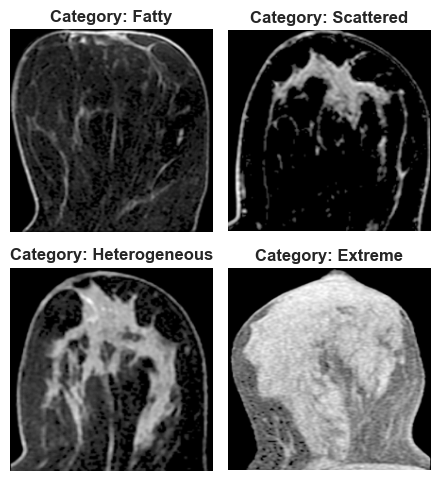

In [17]:
data_path = "E:/Apply/Computer Methods and Programs in Biomedicine/Fig 2/Original Images/"

volume_idx_list = [46, 36, 18, 64]

sample_middle_slices = []
for idx in volume_idx_list:
    img = cv2.imread(data_path + str(idx) + ".png", cv2.IMREAD_GRAYSCALE)
    sample_middle_slices.append(img.astype(np.float32))

class_list = ['Fatty', 'Scattered', 'Heterogeneous', 'Extreme']
              
fig, axes = plt.subplots(2, 2, figsize=(4.5, 5))
axes = axes.flatten()

for i in range(4):
        axes[i].imshow(sample_middle_slices[i], cmap='gray')
        axes[i].set_title(f"Category: {class_list[i]}", fontsize=12, fontweight='bold')
        axes[i].axis('off')

plt.tight_layout()
plt.show()

fig.savefig("E:/Apply/Computer Methods and Programs in Biomedicine/Fig 2//Fig 2.tiff", dpi=300, bbox_inches='tight', format='tiff')